# "Machine learning challenge at datarevenue"
> "Report for the machine learning challenge at datarevenue"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [takehome, jupyter]
- image: images/2020-09-24-ml-challenge/flowchart.png
- hide: false
- search_exclude: false

# Introduction

The goal of this [machine learning challenge](https://github.com/datarevenue-berlin/code-challenge-2020) is to check if I can build an _end-to-end_ machine learning pipeline to predict the `points` for a given wine review based on attributes such as `price`, `region_1`, `variety`, `windery` etc.This is a proof-of-concept for a full-production solution that will be deployed at the client. In this report, I will detail the steps that I have taken and the approaches that I have followed to understand, validate, analyze and build machine learning model

In the wine rating, `points` measure the quality of wine which for the sample data varies from 80 to 100. The remaining 12 coloumns are `country`, `description`, `designation`, `price`, `province`, `region_1`, `region_2`, `taster_name`, `taster_twitter_handle`, `title`, `variety` and `winery`. In the exploratory data analysis (EDA) section, I will mention more details about each variables

The report is organized as follows
  - I will cover the exploratory analysis of each column in the data and mention what are the best way to handle each tag in terms of imputation, scaling/encoding, feature engineering etc
  - In the second section, I will introduce the tasks created for this _end-to-end_ project and mention what goes on with in each task
  - In the third section, I will discuss about the model results and it's relevancy. If the model is relevant, I will also discuss about the model's important features
  - In the last section, I will discuss about the flexibility in deploying this model because of the `retrain` option


# Exploratory data analysis

#hide
!pip install dython
!pip install squarify
!pip install missingno
!pip install wordcloud
!python -m spacy download en_core_web_sm

## Imports

Let's load all the import needed for the dataset at the beginning 

In [1]:
#collapse
import dython
import spacy
import squarify
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# set this to avoid correlation computations
fast = False 

## Load data

The dataset is available as `wine_dataset.csv`. Let's load the dataset as a pandas dataframe to access it's wide range of convenient options. It was mentioned in the challenge to consider `dask`, so that pipeline can run on large datasets, But pandas is preferred to acccess it's wide range of functions and utilities for data analysis with in the limited time. Transposed view of the dataframe can be viewed below

In [2]:
#collapse
df = pd.read_csv('/usr/share/data/raw/wine_dataset.csv')
df.head(n=3).T

,0,1,2
Unnamed: 0,0,1,2
country,Italy,France,Italy
description,"Fragrances suggest hay, crushed tomato vine an...","Packed with fruit and crisp acidity, this is a...","This easy, ruby-red wine displays fresh berry ..."
designation,Kirchleiten,NaN,NaN
points,90,87,86
price,30,22,NaN
province,Northeastern Italy,Loire Valley,Tuscany
region_1,Alto Adige,Sancerre,Chianti Classico
region_2,NaN,NaN,NaN
taster_name,Kerin O’Keefe,Roger Voss,NaN


Out of 13 columns in the dataset, only 3 columns are numerical and the remanining columns are categorical or text based

In [3]:
#collapse
categorical_cols = list(df.select_dtypes(include='object').columns)
numerical_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)

f"Categorical columsn are {categorical_cols}"
f"Numerical columns are {numerical_cols}"

"Categorical columsn are ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']"

"Numerical columns are ['Unnamed: 0', 'points', 'price']"

## Missing fraction

Let's look at the amount of data missing per column. The grey color shows the fraction of data available and white color shows the fraction of data missing

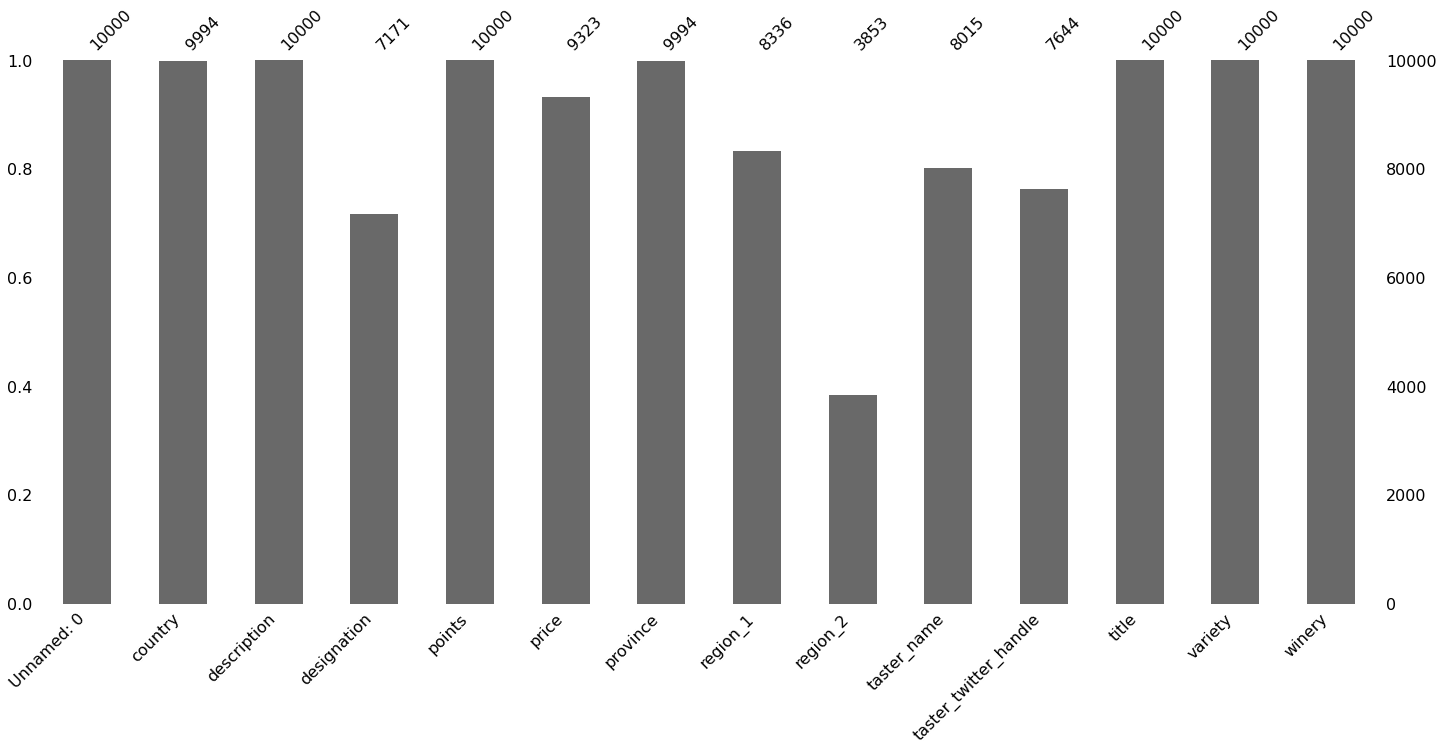

In [4]:
#collapse
msno.bar(df);

Let's look at `region_2` since it has more than 50% of missing data. Even though `region_2` has more than 50% of missing data, it provides some supplemental information to the wine along with `region_1`, `region_2` is not discarded from the analysis

In [5]:
df['region_2'].value_counts(dropna=False, normalize=True)

NaN                  0.6147
Central Coast        0.0847
Sonoma               0.0685
Columbia Valley      0.0611
Napa                 0.0521
Willamette Valley    0.0259
California Other     0.0214
Finger Lakes         0.0142
Sierra Foothills     0.0105
Napa-Sonoma          0.0087
Central Valley       0.0071
Southern Oregon      0.0060
Oregon Other         0.0059
North Coast          0.0059
Long Island          0.0054
Washington Other     0.0046
South Coast          0.0019
New York Other       0.0014
Name: region_2, dtype: float64

Let's look at `designation` column which has at least 30% of missing data

In [6]:
df['designation'].value_counts(dropna=False, normalize=True)

NaN                      0.2829
Reserve                  0.0165
Reserva                  0.0104
Estate                   0.0094
Estate Grown             0.0057
                          ...  
Heritage Reserve         0.0001
Hawk Creek Vineyard      0.0001
Mountain Cuvée Estate    0.0001
Ferrington Vineyard      0.0001
La Dame Rousse           0.0001
Name: designation, Length: 5382, dtype: float64

`designation` has high cardinality with 5382 unique values, which is more than 50% of the data

## Correlation

Let's compute correlation for the entire dataset. `dython` identifies the type of variable and tries to compute correlation in a reasonable way

In [7]:
#collapse 
from dython.nominal import associations
if not fast:
    corr = associations(df.sample(frac=0.5).copy(), figsize=(15, 15))

The heatmap shows the following things
1. `taster_name` and `taster_twitter_handle` have strong correlation `1.0`. So `taster_twitter_handle` can be removed
2. `price` and `points` are NOT following any association in it's original form
2. Association between a categorical column with high cardinality and other variable is high. The association is measured using `Thiels U` score is biased towards high cardinal categorical features

## Duplicate rows

A row is considered as duplicate if it has the same `description`, `title` and `taster_name` with other rows. Some of the duplicate rows are mentioned below along with their index. Transposed view of the dataframe can be viewed below

In [8]:
#collapse
duplicates = df[df.duplicated(subset=['description','title', 'taster_name'], keep=False)]
print(f'Number of duplicate rows is {duplicates.shape[0]/2}')
duplicates.sort_values(['description', 'title', 'taster_name']).head(3).T

Number of duplicate rows is 58.0


,5727,8374,1668
Unnamed: 0,5727,8374,1668
country,France,France,US
description,"A blend of Grenache Blanc and Viognier, this i...","A blend of Grenache Blanc and Viognier, this i...","A full 13 years old, the aromas are still vibr..."
designation,NaN,NaN,NaN
points,85,85,92
price,8,8,42
province,France Other,France Other,Washington
region_1,Vin de France,Vin de France,Columbia Valley (WA)
region_2,NaN,NaN,Columbia Valley
taster_name,Roger Voss,Roger Voss,Sean P. Sullivan


Since duplicate rows doesn't add any additional information, they will be dropped

In [9]:
#collapse
df = df.drop_duplicates(subset=['description', 'title', 'taster_name'], keep='first')

## Columns

Let's look at each column one-by-one and check for it's missingness, uniqueness, and decide on how to impute, transform and encode each column for the final model

### `Unnamed: 0`

`'Unnamed: 0'` indexes the rows of the dataset. So the column can be removed from the dataset as it doesn't add any information

"Numerical columns after removing 'Unnamed: 0' are ['points', 'price']"

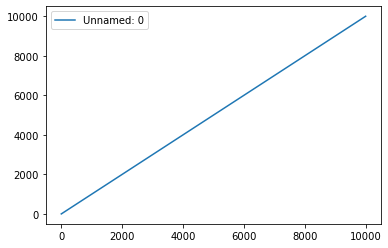

In [10]:
#collapse
df[['Unnamed: 0']].plot();

numerical_cols = [c for c in numerical_cols if c != 'Unnamed: 0']
df.drop(labels=['Unnamed: 0'], axis='columns', inplace=True)

f"Numerical columns after removing 'Unnamed: 0' are {numerical_cols}"

### `taster_twitter_handle`

`taster_twitter_handle` has high correlation, close to `1` with `taster_name`. So `taster_twitter_handle` will be dropped

In [11]:
#collapse
categorical_cols = [c for c in categorical_cols if c != 'taster_twitter_handle']
df.drop(labels=['taster_twitter_handle'], axis='columns', inplace=True)

f"Categorical columns after removing 'taster_twitter_handle' are \n{categorical_cols}"

"Categorical columns after removing 'taster_twitter_handle' are \n['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'title', 'variety', 'winery']"

### `price`

`price` represents the cost of the wine under review

#### info

75% of the wines reviewed costs less than $42. The distribution is heavily skewed. So scaling must be done properly to ensure that low priced wines `price` are properly represented in the dataset

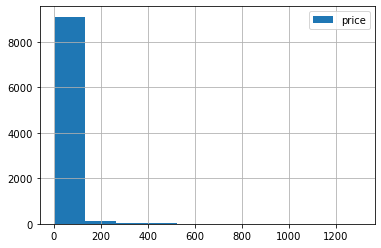

In [12]:
#collapse
df['price'].describe()
df['price'].hist(legend=True);

#### vs points

The relationship between `price` and `points` can help in easily identifying any relationship between them

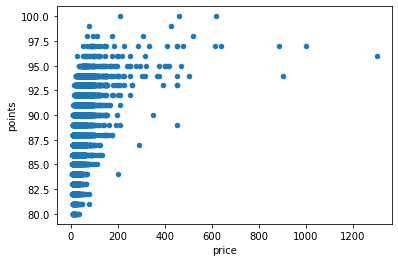

In [13]:
#collapse
df[['price', 'points']].plot.scatter(x='price', y='points')
plt.show();

#### scaling

Due to it's skewness, `log` scaling can help in reducing the skewness. The scaled and transformed makes it easy to understand the relation between points and log transformed price. The correlation increased by ~0.1 from its raw representation

,price,points
price,1.000000,0.608184
points,0.608184,1.000000


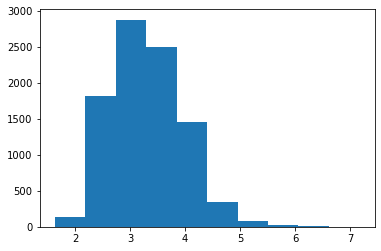

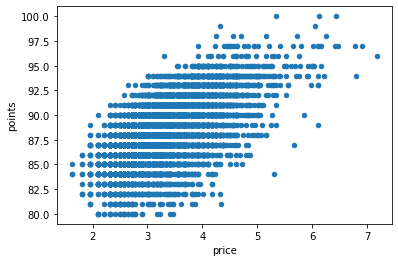

In [14]:
#collapse
df['price'] = df['price'].transform(lambda x: np.log(x + 0.1))
_ = plt.hist(df['price'])
_ =df[['price', 'points']].plot.scatter(x='price', y='points')
df[['price', 'points']].corr()

#### imputation

We can use median of log transformed value to impute the missing values as the log-distribution is close to gaussian distribution. `price` has `6.7%` of missing values and they will be replaced with median value of the column

In [15]:
#collapse
print('Missing data for price column before imputation')
df['price'].value_counts(dropna=False, normalize=True)*100
df['price'] = df['price'].fillna(value=df['price'].median())

print('\nNo missing data for price column after imputation')
df['price'].value_counts(dropna=False, normalize=True)*100

Missing data for price column before imputation


NaN         6.799437
3.000720    5.089519
2.714695    4.948702
3.222868    4.154094
3.404525    3.902635
              ...   
5.720640    0.010058
5.342813    0.010058
6.254021    0.010058
4.970508    0.010058
5.328361    0.010058
Name: price, Length: 189, dtype: float64


No missing data for price column after imputation


3.222868    10.953530
3.000720     5.089519
2.714695     4.948702
3.404525     3.902635
2.895912     3.852344
              ...    
5.720640     0.010058
5.342813     0.010058
6.254021     0.010058
6.214808     0.010058
5.328361     0.010058
Name: price, Length: 188, dtype: float64

### `country`

`country` represents the country from which the wine is from. There are 37 countries in the reviews. So on an average, each country representation is 268 wines

#### info

In [16]:
#collapse
column = 'country'
df[column].describe()

count     9936
unique      37
top         US
freq      4130
Name: country, dtype: object

Let's look at how the reviews are distributed among countries. `US`, `France` and `Italy` occupy chunk of the wine reviews while India, Switzerland and Peru doesn't seem to have lot of wineries

In [17]:
df[column].value_counts()

US                4130
France            1724
Italy             1470
Spain              519
Portugal           423
Chile              355
Argentina          309
Austria            267
Germany            164
Australia          161
South Africa       114
New Zealand        101
Israel              52
Greece              34
Canada              17
Bulgaria            13
Romania             11
Hungary             10
Uruguay              9
Croatia              7
England              7
Slovenia             6
Mexico               6
Turkey               5
Moldova              4
Georgia              3
Lebanon              3
Czech Republic       2
Serbia               2
Macedonia            1
India                1
Brazil               1
Cyprus               1
Switzerland          1
Armenia              1
Peru                 1
Morocco              1
Name: country, dtype: int64

#### vs points

The dataframe can be `grouped` by the country to get average `points` per country

In [18]:
#collapse
avg_points_per_c = df[[column, 'points']].groupby(by=[column]).median().sort_values(by=['points'])
country_obs_c = df[[column, 'points']].groupby(by=[column]).count().sort_values(by=['points'], ascending=False)
avg_points_per_c.loc[:, 'count'] = country_obs_c.loc[avg_points_per_c.index, 'points']

There's isn't much seperation in `points` between countries with high representation and countries with least representation

In [19]:
#collapse
avg_points_per_c.sort_values(by='count', ascending=False).head(n=10)
avg_points_per_c.sort_values(by='count', ascending=False).tail(n=10)

,points,count
country,,
US,89.0,4130
France,88.0,1724
Italy,88.0,1470
Spain,87.0,519
Portugal,88.0,423
Chile,87.0,355
Argentina,86.0,309
Austria,90.0,267
Germany,90.0,164


,points,count
country,,
Czech Republic,87.5,2
Serbia,87.5,2
Brazil,88.0,1
Morocco,89.0,1
Armenia,87.0,1
Cyprus,85.0,1
Macedonia,85.0,1
India,90.0,1
Switzerland,90.0,1


Wines from Germany, Austria on an average has high points while Romania and Argentina are on the lowered side. But since the difference is by a margin on four points (90 vs 86). So there isn't lot of variation among wines from countries when compared to individual wines

In [20]:
#collapse
avg_points_per_c[avg_points_per_c['count'] > 10].sort_values(by='points', ascending=False).head(n=10)
avg_points_per_c[avg_points_per_c['count'] > 10].sort_values(by='points', ascending=False).tail(n=10)

,points,count
country,,
Germany,90.0,164
Austria,90.0,267
Australia,89.0,161
New Zealand,89.0,101
US,89.0,4130
Canada,89.0,17
Bulgaria,89.0,13
Israel,89.0,52
Portugal,88.0,423


,points,count
country,,
Israel,89.0,52
Portugal,88.0,423
Italy,88.0,1470
South Africa,88.0,114
France,88.0,1724
Greece,87.5,34
Chile,87.0,355
Spain,87.0,519
Romania,86.0,11


In the square plot below, the country which has more points on an average has more area on the plot

Number of country 37


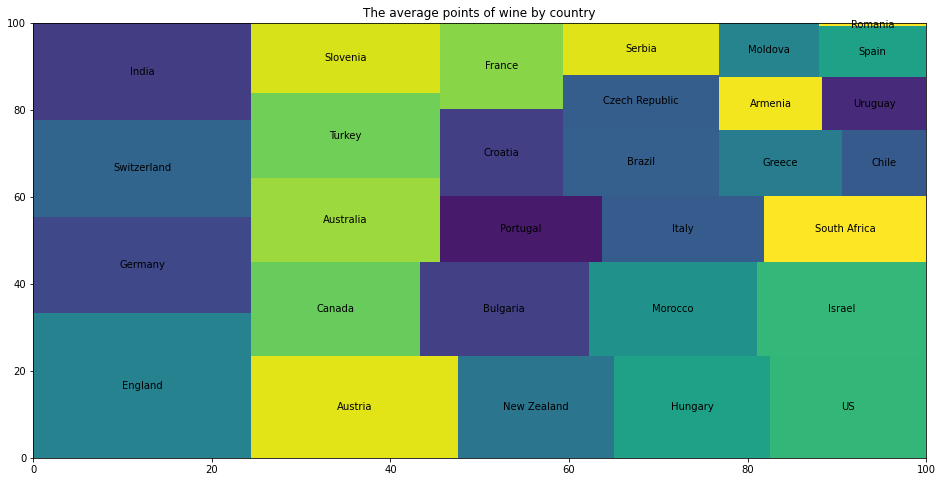

In [21]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can either use `US` or a new `unknown-country` to impute the missing data. One other way of imputing the data is to use the available categories(37) and create a distribution with category probability associated with normalized value counts

In [22]:
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

In [23]:
#collapse
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit_transform(df[[column]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

Since the number of available categories is less than 50, we _may_ not have to worry about the cardinality for `country` variable

### `description`

There are as many descriptions as the number of reviews. It looks like, each review is unique (It should be since we removed the duplicates). This variable should be treated as a text variable.

In [24]:
#collapse
column = 'description'
df[column].describe()

count                                                  9942
unique                                                 9942
top       A tannic, structured wine, full of rich stone ...
freq                                                      1
Name: description, dtype: object



There are several ways to take advantage of the `description` of review. One hypothesis is frequent usage of praise words can be seen as a positive review and hence more points. Let's do `TF-IDF` of `description` and see which words appear more in the high score reviews vs low score reviews. We can also do a word cloud representation of the descriptions to see what words appeared more in the description

### word cloud

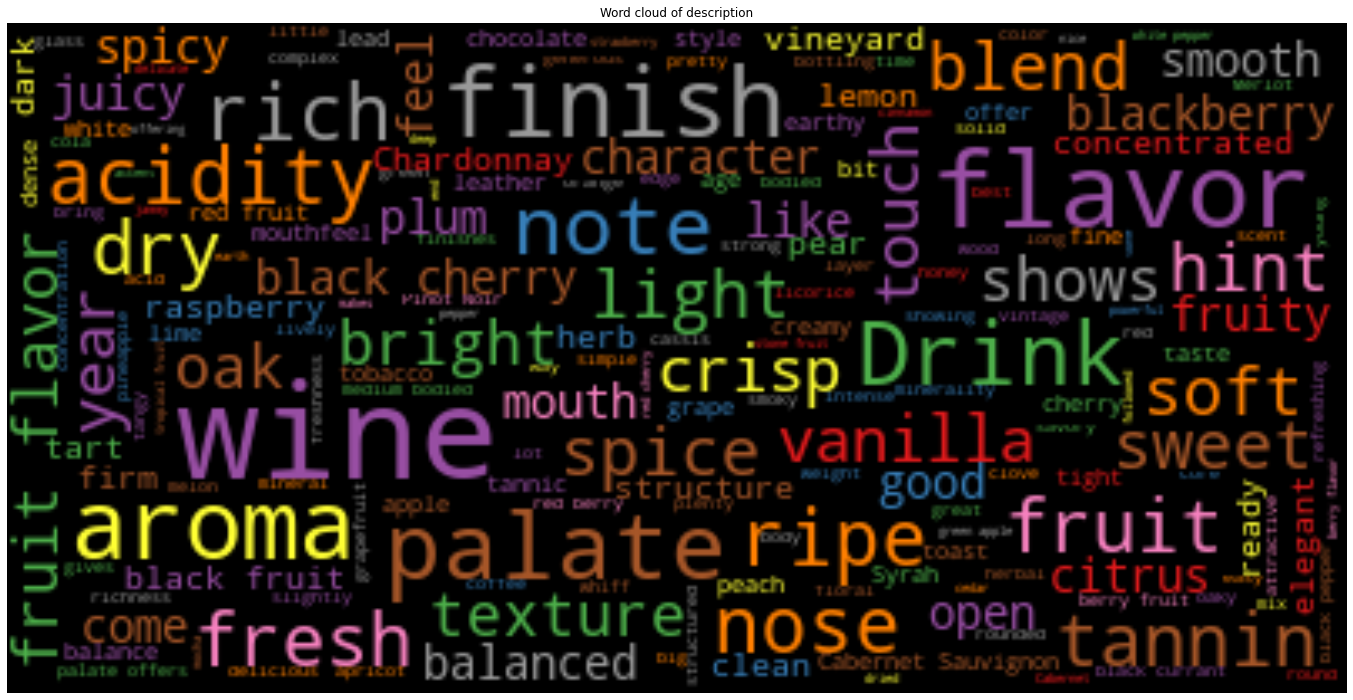

In [25]:
#collapse
plt.figure(figsize= (24, 16))
plt.title(f'Word cloud of {column}')
wc = WordCloud(max_words=1000, max_font_size=40,background_color='black', stopwords = spacy_stopwords,colormap='Set1')
wc.generate(' '.join(df[column]))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off');

All the words appeared to be in English language. So we make assumption all the descriptions are English only. This assumption is important in word tokenization

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-description` to impute the missing data

In [26]:
#collapse
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

For high cardinal features, we can use truncated svd to reduce the dimensionality of Tf-Idf matrix

In [27]:
#collapse
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

We can use tokenization from `Spacy` and create Tf-Idf representation of the description column

In [28]:
#collapse
# load the language model and enable only the tokenization component
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

tfv = TfidfVectorizer(tokenizer=lambda x: [t.lemma_ for t in nlp(x) if len(t.lemma_) > 1], token_pattern=None, stop_words=spacy_stopwords)
tfv.fit(df[column])
len(tfv.vocabulary_) # Number of words across the corupus of description

corpus_transformed = tfv.transform(df[column])
svd = decomposition.TruncatedSVD(n_components=75)
corpus_svd = svd.fit(corpus_transformed)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'far', 'good', 'little', 'regard', 'use', '\ufeff1'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another', 'any', ...},
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7fa62f0a7160>)

9435

To avoid column explosion, let's limit the `n_components` in svd to get to at least 20% of the variance in the data. 20% is lot of trade-off but this is one of the factors that we can come back to later while improving model predictions. A single column of `description` will be expanded to 75 other columns

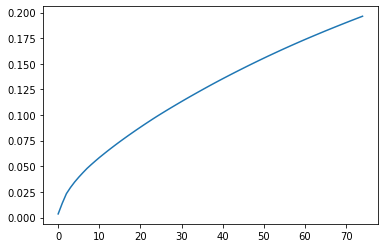

In [29]:
plt.plot(svd.explained_variance_ratio_.cumsum());

### `title`

It looks like, each review is unique (It should be since we removed the duplicates). This variable should also be treated as a text varirable

In [30]:
#collapse
column = 'title'
df[column].describe()

count                                                  9942
unique                                                 9930
top       Ca' del Bosco NV Cuvée Prestige Sparkling (Fra...
freq                                                      3
Name: title, dtype: object

#### word cloud

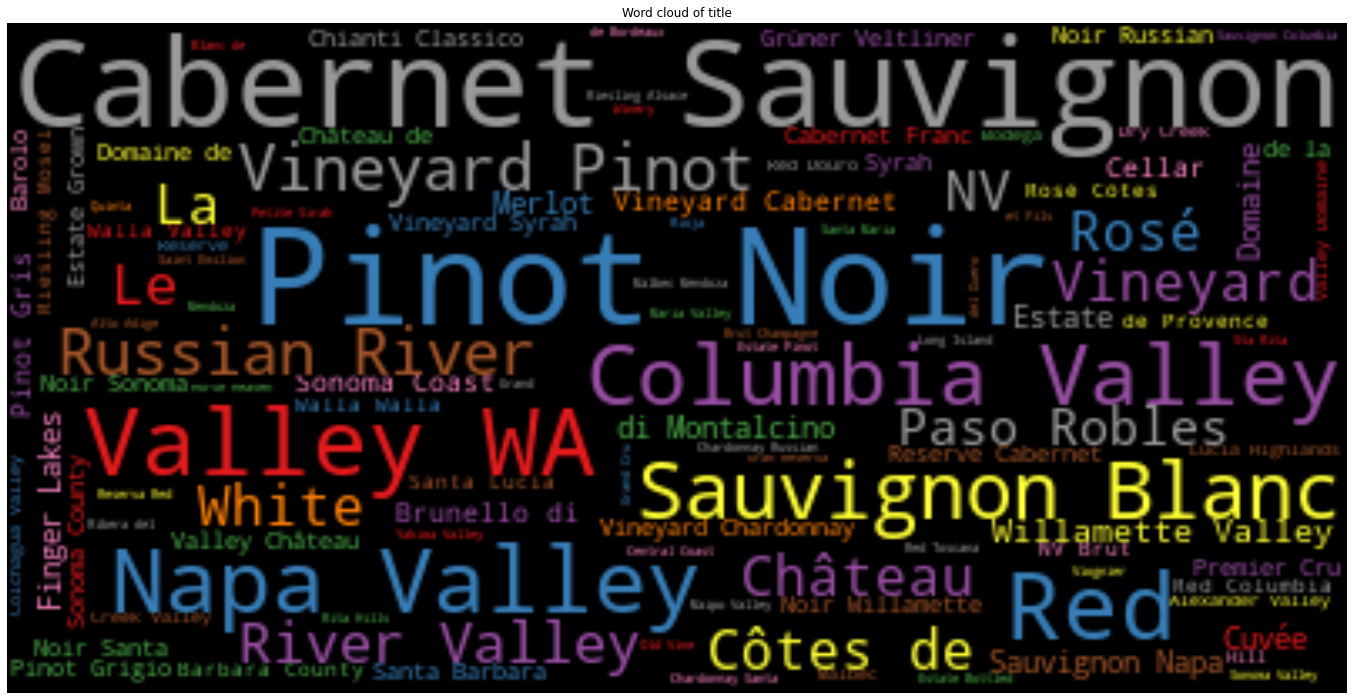

In [31]:
#collapse
plt.figure(figsize= (24, 16))
plt.title(f'Word cloud of {column}')
wc = WordCloud(max_words=1000, max_font_size=40,background_color='black', stopwords = spacy_stopwords,colormap='Set1')
wc.generate(' '.join(df[column]))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off');

All the words appeared to be in English language. So we make assumption that description will be in English only. This assumption is important in word tokenization

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-title` to impute the missing data

In [32]:
#collapse
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

For high cardinal features, we can use truncated svd to reduce the dimensionality of Tf-Idf matrix

In [33]:
#collapse
# load the language model and enable only the tokenization component
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])

tfv = TfidfVectorizer(tokenizer=lambda x: [t.lemma_ for t in nlp(x) if len(t.lemma_) > 1], token_pattern=None, stop_words=spacy_stopwords)
tfv.fit(df[column])
len(tfv.vocabulary_) # Number of words across the corupus of description

corpus_transformed = tfv.transform(df[column])
svd = decomposition.TruncatedSVD(n_components=75)
corpus_svd = svd.fit(corpus_transformed)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'far', 'good', 'little', 'regard', 'use', '\ufeff1'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another', 'any', ...},
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7fa66245ed30>)

11027

To avoid column explosion, let's limit the `n_components` in svd to get to atleast 20% of the variance in the data. A single column of `text` will be expanded to 75 other columns

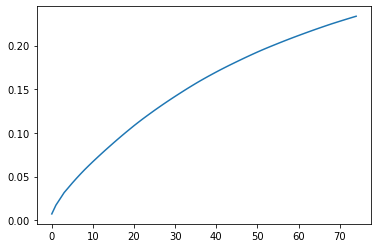

In [34]:
#collapse
plt.plot(svd.explained_variance_ratio_.cumsum());

### `variety`

`variety` represents how many grapes are used in the wine

#### info

In [35]:
#collapse
column = 'variety'

df[column].describe()
df[column].nunique()/len(df) * 100

count           9942
unique           333
top       Pinot Noir
freq            1007
Name: variety, dtype: object

3.349426674713337

Unique values for `variety` is ~ 3.3% percent. And some of the wine are made for mix of two types 

In [36]:
df[column].value_counts()

Pinot Noir                  1007
Chardonnay                   946
Cabernet Sauvignon           763
Red Blend                    697
Bordeaux-style Red Blend     521
                            ... 
Elbling                        1
Lemberger                      1
Tocai Friulano                 1
Lambrusco Grasparossa          1
Malvasia Bianca                1
Name: variety, Length: 333, dtype: int64

Looking at the string length of some the varieties, it looks like some of the wines are from more than one grape type, a mix.

8827    Cabernet Sauvignon-Cabernet Franc
1927    Cabernet Franc-Cabernet Sauvignon
1566    Cabernet Sauvignon-Cabernet Franc
4915     Cabernet Sauvignon-Merlot-Shiraz
622        Tempranillo-Cabernet Sauvignon
                      ...                
8293                                 Rosé
4483                                 Rosé
8333                                 Rosé
817                                  Port
4680                                 Rosé
Name: variety, Length: 9942, dtype: object

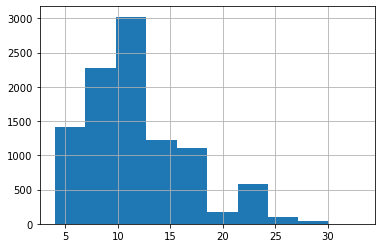

In [37]:
#collapse
df[column].apply(lambda x: len(x)).hist();
df[column].loc[df[column].apply(lambda x: len(x)).sort_values(ascending=False).index]

`Cabernet Sauvignon-Cabernet Franc` and `Cabernet Franc-Cabernet Sauvignon` are displayed as two unique values eventhough they are same. So let's adjust that

In [38]:
#collapse
df[column] = df[column].apply(lambda x: '-'.join(sorted(x.split('-'))))
df[column].loc[df[column].apply(lambda x: len(x)).sort_values(ascending=False).index]

8827    Cabernet Franc-Cabernet Sauvignon
1927    Cabernet Franc-Cabernet Sauvignon
1566    Cabernet Franc-Cabernet Sauvignon
4915     Cabernet Sauvignon-Merlot-Shiraz
622        Cabernet Sauvignon-Tempranillo
                      ...                
8293                                 Rosé
4483                                 Rosé
8333                                 Rosé
817                                  Port
4680                                 Rosé
Name: variety, Length: 9942, dtype: object

#### vs points

There isn't lot of variation, on an average, for variety vs points

In [39]:
#collapse
df.groupby([column])['points'].median().sort_values(ascending=False)[:30]

variety
Scheurebe                           95.0
Alsace white blend                  94.0
Trousseau Gris                      93.0
Assyrtiko                           93.0
Austrian white blend                93.0
Petit Manseng                       93.0
Bual                                93.0
Kotsifali                           92.0
Black Muscat                        92.0
Tinta Negra Mole                    92.0
Cabernet Sauvignon-Sangiovese       92.0
Malbec-Tannat                       92.0
Picolit                             92.0
Provence red blend                  92.0
Shiraz-Viognier                     92.0
Cinsault                            91.0
Listán Negro                        91.0
Sämling                             91.0
Touriga Nacional                    91.0
Muscat Canelli                      91.0
Counoise                            91.0
Gros Manseng                        91.0
Cabernet Sauvignon-Merlot-Shiraz    91.0
Mantonico                           91.0
Sherry  

In the square plot below, the variety which has more points on an average has more area on the plot. The colors are random and can change on each run

Number of variety 321


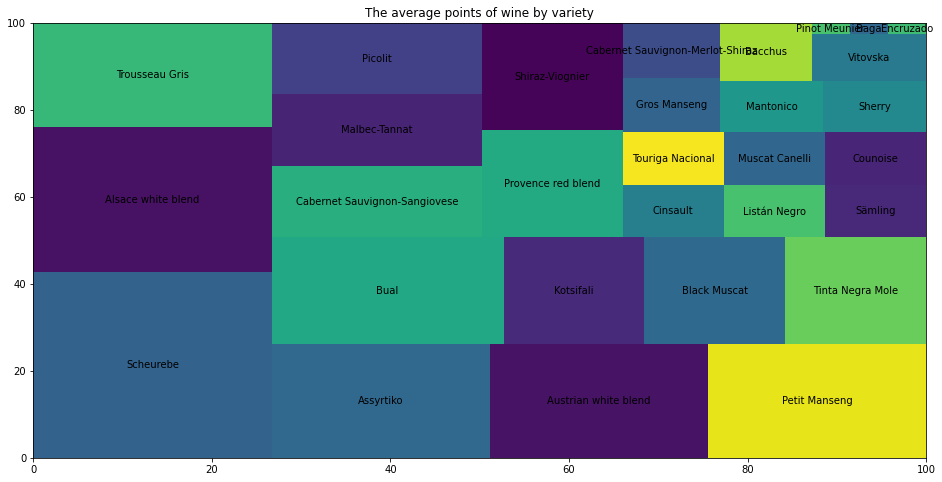

In [40]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

#### feature engineering

Let's see if number of grapes has any impact on the `points` received for that respective wine

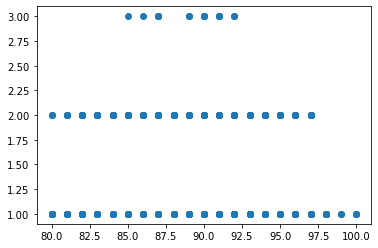

In [41]:
#collapse
plt.scatter(df.points.values, df[column].apply(lambda x: len(x.split('-'))).values);

We can notice that certain types of blends (2 or more) have narrow region of points. We can use this to engineer a new feature that represents to the types of grapes used for the wine

In [42]:
df[f'{column}-count'] = df[column].apply(lambda x: len(x.split('-')))

#### word cloud

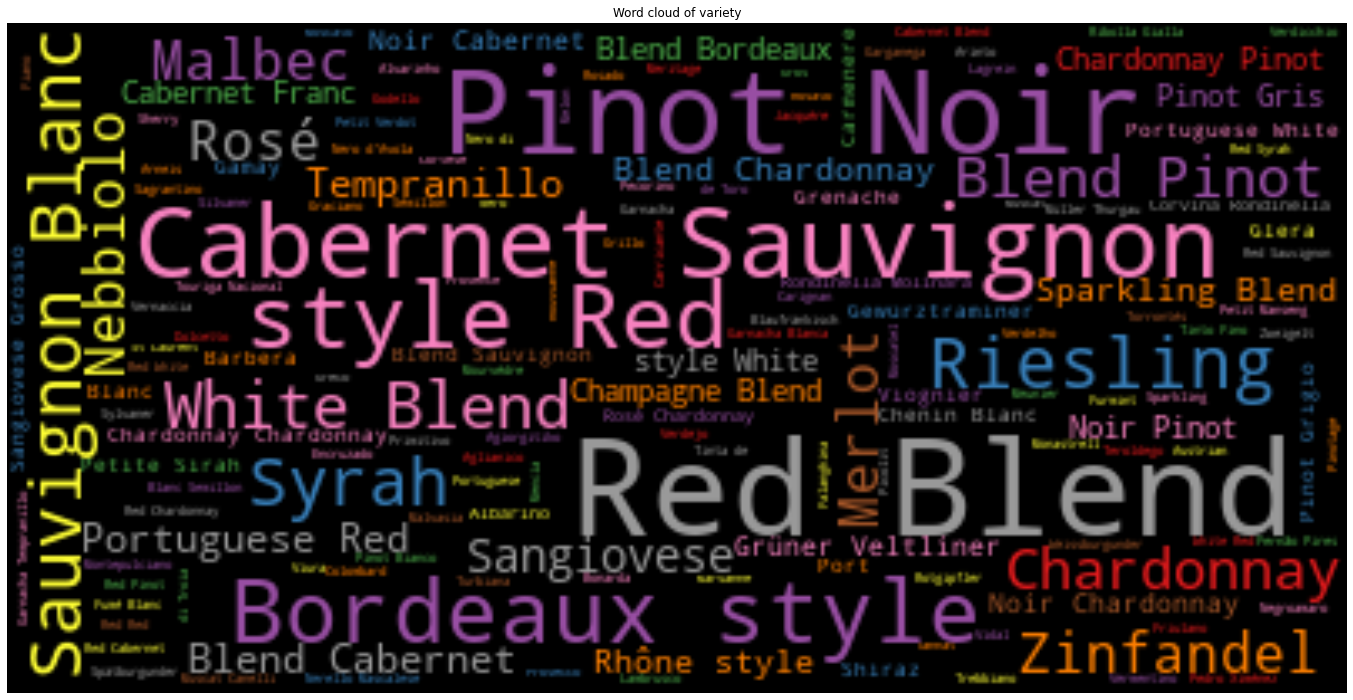

In [43]:
#collapse
plt.figure(figsize= (24, 16))
plt.title(f'Word cloud of {column}')
wc = WordCloud(max_words=1000, max_font_size=40,background_color='black', stopwords = spacy_stopwords,colormap='Set1')
wc.generate(' '.join(df[column]))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off');

All the words appeared to be in English language. But the variable represents categorical data rather than text data. So let's `one-hot` encode `variety` and then reduce the dimensionality using `TruncatedSVD`. `Pinot`, `Red Blend` `Cabernet` are some of the most common ones

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-variety` to impute the missing data

In [44]:
#collapse
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

We can onehot encode the categorical feature and use `TruncatedSVD` to avoid column explosion, let's limit the `n_components` in svd to get to atleast 80% of the variance in the data (since we used one-hot encoding and not TF-IDF)

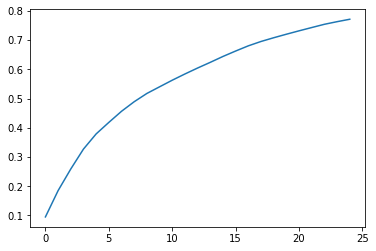

In [45]:
#collapse

# load the language model and enable only the tokenization component
svd = decomposition.TruncatedSVD(n_components=25)
corpus_svd = svd.fit(pd.get_dummies(df[column]))

plt.plot(svd.explained_variance_ratio_.cumsum());

### `winery`

`winery` represents the name of the winery where it got developed over the days

#### info

The wines come from different wineries and the maximum number of bottles from a winery is 19 which 0.19% of total observations. Also, the wineries with lot of reviews doesn't have much change from the median points (88). So there isn't much signal in this column and thus can be dropped from the analysis

In [46]:
column = 'winery'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts()

count                      9942
unique                     5460
top       Chateau Ste. Michelle
freq                         19
Name: winery, dtype: object

54.918527459263736

Chateau Ste. Michelle        19
Columbia Crest               17
Georges Duboeuf              17
Lynmar                       16
DFJ Vinhos                   15
                             ..
Tercero                       1
Santos & Seixo                1
Quinta do Perdigão            1
Gernot and Heike Heinrich     1
Château Béhèré Courtin        1
Name: winery, Length: 5460, dtype: int64

So let's drop winery and use either `region_1` and `region_2` to get similar information

In [47]:
#collapse
categorical_cols = [c for c in categorical_cols if c != column]
df.drop(labels=[column], axis='columns', inplace=True)

### `designation`

There are too many designations and even the top designations doesn't have any signal in the data. So this column can be dropped from the analysis

In [48]:
#collapse
column = 'designation'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts()

count        7129
unique       5381
top       Reserve
freq          165
Name: designation, dtype: object

54.12391872862603

Reserve                            165
Reserva                            104
Estate                              93
Estate Grown                        56
Riserva                             50
                                  ... 
El Cerezo Unoaked                    1
Thorn Ridge Vineyard                 1
Pink Moscato                         1
Taos Dry Red Wine                    1
Brut Rosé Méthode Traditionelle      1
Name: designation, Length: 5381, dtype: int64

### `province`

#### info

Number of unique values for `province` is `<3`. This columns can be treated similar to `variety`

In [49]:
#collapse
column = 'province'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts()

count           9936
unique           248
top       California
freq            2741
Name: province, dtype: object

2.4944679139006234

California               2741
Washington                653
Tuscany                   458
Bordeaux                  455
Oregon                    403
                         ... 
Bulgaria                    1
Germany                     1
Choapa Valley               1
Portuguese Table Wine       1
Ankara                      1
Name: province, Length: 248, dtype: int64

193 out of 248 unique `province`s have less than 25 wines in the reviews

In [50]:
df[column].value_counts()[df[column].value_counts() < 25]

Victoria                 24
Cachapoal Valley         21
Western Australia        20
Australia Other          20
Idaho                    19
                         ..
Bulgaria                  1
Germany                   1
Choapa Valley             1
Portuguese Table Wine     1
Ankara                    1
Name: province, Length: 193, dtype: int64

#### word cloud

California and Washington are most common `provinces`

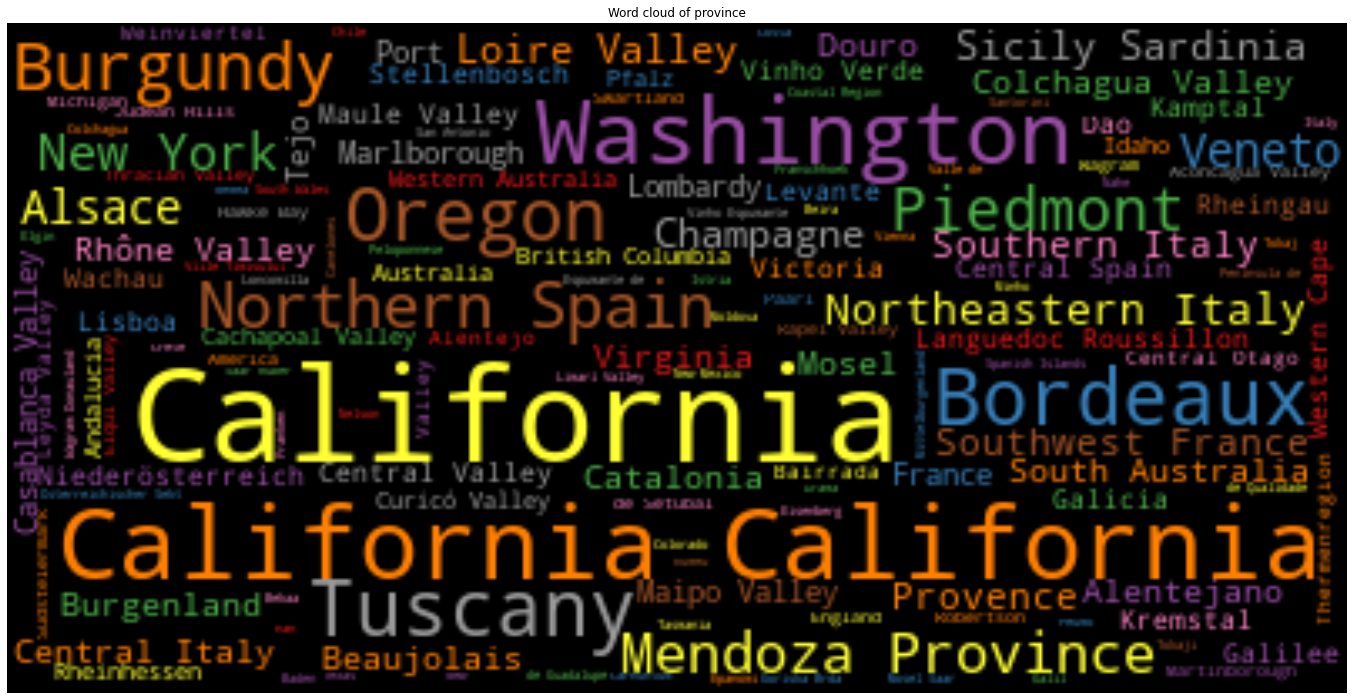

In [51]:
plt.figure(figsize= (24, 16))
plt.title(f'Word cloud of {column}')
wc = WordCloud(max_words=1000, max_font_size=40,background_color='black', stopwords = spacy_stopwords,colormap='Set1')
wc.generate(' '.join(df[column].astype(str)));
plt.imshow(wc,interpolation="bilinear");
plt.axis('off');

The variable represents categorical data rather than text data like `title` and `description`. So let's `one-hot` encode `province` and then reduce the dimensionality using `TruncatedSVD`

In [52]:
# collapse 
df.groupby([column])['points'].median().sort_values(ascending=False)[:30]

province
Santa Cruz                 93.0
Hemel en Aarde             93.0
Südburgenland              93.0
Puente Alto                93.0
Wachau                     92.5
Madeira                    92.5
England                    92.0
Vienna                     92.0
Waiheke Island             92.0
Buin                       92.0
Traisental                 92.0
Ribatejano                 92.0
Rheingau                   92.0
Wiener Gemischter Satz     91.5
Kumeu                      91.0
Mittelrhein                91.0
Tasmania                   91.0
Mittelburgenland           91.0
Eisenberg                  91.0
Swartland                  91.0
Overberg                   91.0
Spanish Islands            91.0
Dão                        91.0
Simonsberg-Stellenbosch    91.0
Jerusalem Hills            91.0
Neusiedlersee              91.0
Kremstal                   91.0
Kamptal                    91.0
Moscatel de Setúbal        91.0
Israel                     91.0
Name: points, dtype: float64

There isn't lot of change in the first few boxes. The `points` reduce considerable for some of the `provinces` on the lower end of `points`

Number of province 248


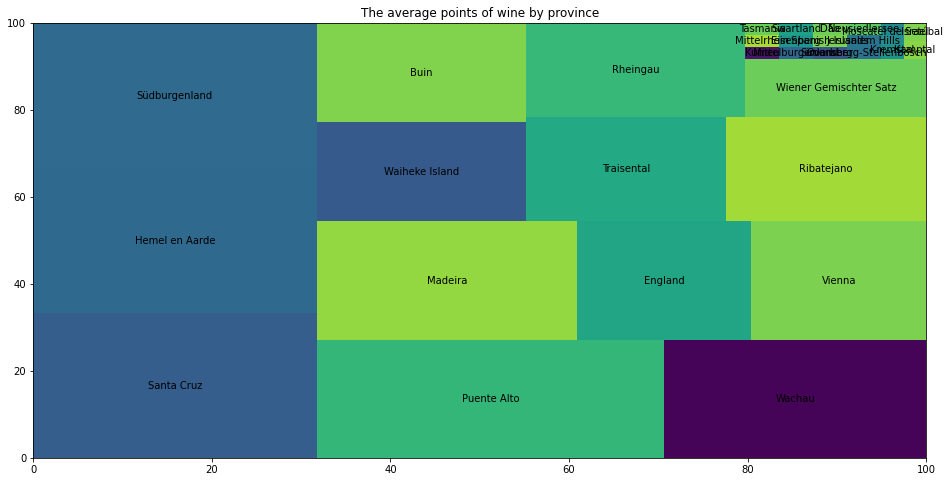

In [53]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-variety` to impute the missing data

In [54]:
df[column] = df[column].fillna(value=f'unknown-{column}')

### encoding

We can onehot encode the categorical feature

In [55]:
pd.get_dummies(df[column]).columns

Index(['Achaia', 'Aconcagua Costa', 'Aconcagua Valley', 'Aegean', 'Alentejano',
       'Alentejo', 'Alsace', 'America', 'Amyndeon', 'Andalucia',
       ...
       'Wellington', 'Western Australia', 'Western Cape',
       'Wiener Gemischter Satz', 'Württemberg', 'Zenata', 'unknown-province',
       'Österreichischer Sekt', 'Štajerska', 'Župa'],
      dtype='object', length=249)

To avoid column explosion, let's limit the `n_components` in svd to get to atleast 80% of the variance in the data (since we used one-hot encoding)

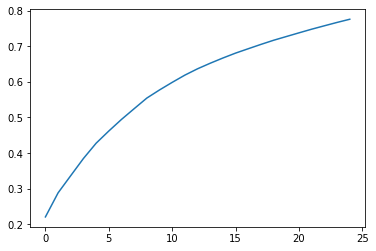

In [56]:
# load the language model and enable only the tokenization component
svd = decomposition.TruncatedSVD(n_components=25)
corpus_svd = svd.fit(pd.get_dummies(df[column]))
plt.plot(svd.explained_variance_ratio_.cumsum());

### `taster_name`

`taster_name` represents the person who reviewd the wine

#### info

Number of unique values for `taster_name` is `18`. This columns can be treated similar to `variety` but without onehot encoding since the number of reviwers is 1% to the number of reviews

In [57]:
column = 'taster_name'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts()

count           7959
unique            18
top       Roger Voss
freq            1947
Name: taster_name, dtype: object

0.18105009052504525

Roger Voss            1947
Michael Schachner     1201
Kerin O’Keefe          854
Paul Gregutt           739
Virginie Boone         713
Matt Kettmann          459
Joe Czerwinski         382
Sean P. Sullivan       358
Anna Lee C. Iijima     334
Jim Gordon             324
Anne Krebiehl MW       292
Lauren Buzzeo          154
Susan Kostrzewa         80
Jeff Jenssen            42
Mike DeSimone           39
Alexander Peartree      26
Carrie Dykes            10
Fiona Adams              5
Name: taster_name, dtype: int64

#### vs points

There are few reviwers who are generous with their points compared to other reviewers. This column seem to have some explanatory power for the `points` column

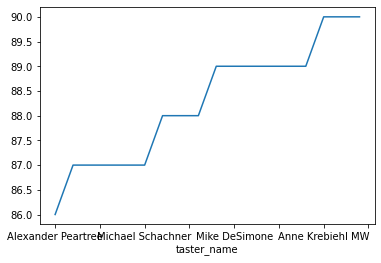

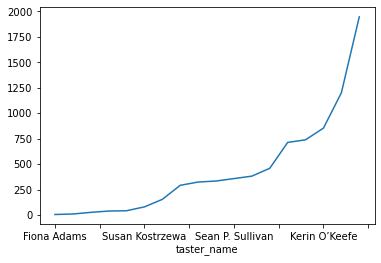

In [58]:
df.groupby(by=[column])['points'].median().sort_values().plot()
plt.show();
df.groupby(by=[column])['points'].count().sort_values().plot();

Number of taster_name 18


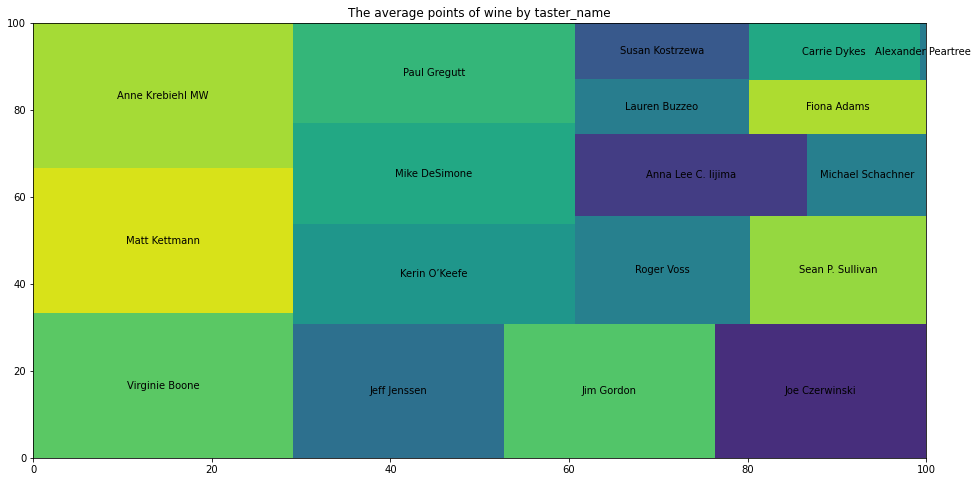

In [59]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-taster_name` to impute the missing data

In [60]:
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

We can onehot encode the categorical feature

In [61]:
pd.get_dummies(df[column]).iloc[:, :10]

,Alexander Peartree,Anna Lee C. Iijima,Anne Krebiehl MW,Carrie Dykes,Fiona Adams,Jeff Jenssen,Jim Gordon,Joe Czerwinski,Kerin O’Keefe,Lauren Buzzeo
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0


### `region_1`

#### info

Number of unique values for `region_1` is `724`. This column can be treated similar to `variety` (onehot encode and truncatedsvd)

In [62]:
#collapse
column = 'region_1'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts()

count            8289
unique            724
top       Napa Valley
freq              349
Name: region_1, dtype: object

7.282236974451821

Napa Valley                 349
Columbia Valley (WA)        342
Russian River Valley        233
California                  211
Willamette Valley           187
                           ... 
Abruzzo                       1
Bardolino Classico            1
Penisola Sorrentina           1
Asolo Prosecco Superiore      1
Yadkin Valley                 1
Name: region_1, Length: 724, dtype: int64

#### vs points

region_1
Vin Santo di Montepulciano    100.0
Clos de la Roche               97.0
Montrachet                     97.0
Chevalier-Montrachet           97.0
Grands-Echezeaux               97.0
                              ...  
Calchaquí Valley               82.5
Tulum Valley                   82.5
Tierra de Castilla             82.0
Swan Creek                     81.0
Missouri                       80.0
Name: points, Length: 724, dtype: float64

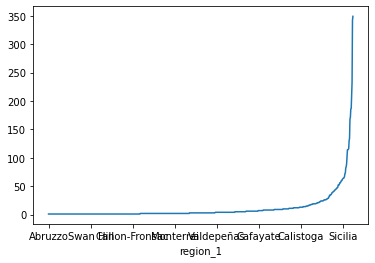

In [63]:
df.groupby(by=[column])['points'].median().sort_values(ascending=False)
df.groupby(by=[column])['points'].count().sort_values().plot()

In [64]:
df.groupby([column])['points'].median().sort_values(ascending=False)[:30]

region_1
Vin Santo di Montepulciano      100.0
Clos de la Roche                 97.0
Montrachet                       97.0
Chevalier-Montrachet             97.0
Grands-Echezeaux                 97.0
Corton-Charlemagne               97.0
Bienvenues Bâtard-Montrachet     97.0
Clos de Lambrays                 96.0
Chambertin                       95.0
Bâtard-Montrachet                94.5
Corton                           94.5
Corton Vergennes                 93.5
Hermitage                        93.5
Pauillac                         93.0
Recioto di Soave Classico        93.0
Red Hills Lake County            93.0
Echézeaux                        93.0
Côte Rôtie                       93.0
Redwood Valley                   93.0
Volnay                           93.0
Alghero                          93.0
Saint-Julien                     93.0
Savennières                      93.0
Sauternes                        93.0
Piccadilly Valley                93.0
Vosne-Romanée                    92.5
For

There are few regions for which the points are high

Number of region_1 724


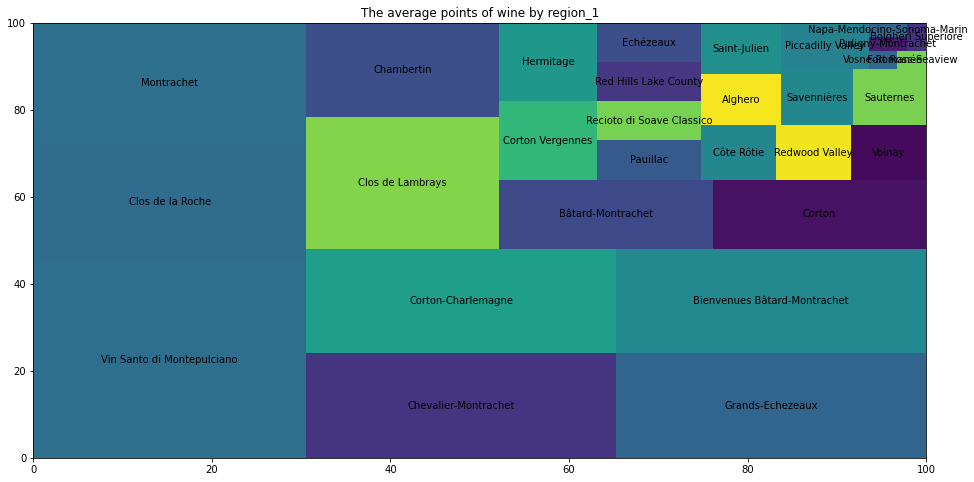

In [65]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-taster_name` to impute the missing data

In [66]:
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

We can onehot encode the categorical feature and then use SVD on the decomposition

In [67]:
pd.get_dummies(df[column]).columns

Index(['Abruzzo', 'Adelaida District', 'Adelaide', 'Adelaide Hills',
       'Aglianico del Taburno', 'Aglianico del Vulture', 'Agrelo', 'Alella',
       'Alexander Valley', 'Alghero',
       ...
       'Western Australia', 'Willamette Valley', 'Yadkin Valley',
       'Yakima Valley', 'Yarra Valley', 'Yolo County', 'Yorkville Highlands',
       'Yountville', 'Zonda Valley', 'unknown-region_1'],
      dtype='object', length=725)

To avoid column explosion, let's limit the `n_components` in svd to get to atleast 50% of the variance in the data (since we used one-hot encoding)

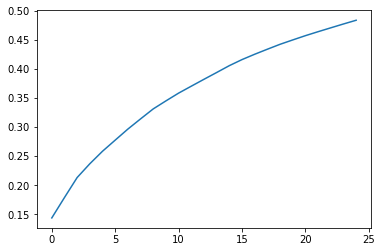

In [68]:
#collapse
# load the language model and enable only the tokenization component
svd = decomposition.TruncatedSVD(n_components=25)
corpus_svd = svd.fit(pd.get_dummies(df[column]))

plt.plot(svd.explained_variance_ratio_.cumsum());

### `region_2`

#### info

Number of unique values for `region_2` is `17`. This columns can be treated similar to `country` (onehot encode)

In [69]:
column = 'region_2'

df[column].describe()
df[column].nunique()/len(df) * 100

df[column].value_counts(dropna=False)

count              3830
unique               17
top       Central Coast
freq                843
Name: region_2, dtype: object

0.17099175216254275

NaN                  6112
Central Coast         843
Sonoma                682
Columbia Valley       606
Napa                  519
Willamette Valley     255
California Other      213
Finger Lakes          142
Sierra Foothills      104
Napa-Sonoma            86
Central Valley         71
Southern Oregon        59
North Coast            59
Oregon Other           58
Long Island            54
Washington Other       46
South Coast            19
New York Other         14
Name: region_2, dtype: int64

#### vs points

region_2
Willamette Valley    90
Napa                 90
Central Coast        89
Sonoma               89
Sierra Foothills     89
Napa-Sonoma          89
Columbia Valley      89
Southern Oregon      88
South Coast          88
Oregon Other         88
Washington Other     88
Long Island          88
North Coast          87
Finger Lakes         87
Central Valley       87
New York Other       86
California Other     86
Name: points, dtype: int64

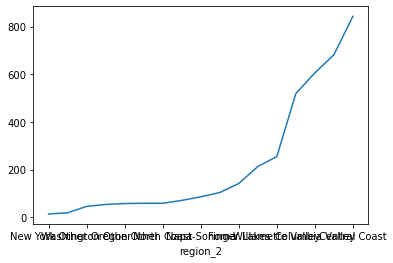

In [70]:
df.groupby(by=[column])['points'].median().sort_values(ascending=False)
df.groupby(by=[column])['points'].count().sort_values().plot()

In [71]:
df.groupby([column])['points'].median().sort_values(ascending=False)[:30]

region_2
Willamette Valley    90
Napa                 90
Central Coast        89
Sonoma               89
Sierra Foothills     89
Napa-Sonoma          89
Columbia Valley      89
Southern Oregon      88
South Coast          88
Oregon Other         88
Washington Other     88
Long Island          88
North Coast          87
Finger Lakes         87
Central Valley       87
New York Other       86
California Other     86
Name: points, dtype: int64

There are few regions for which the points are high

Number of region_2 17


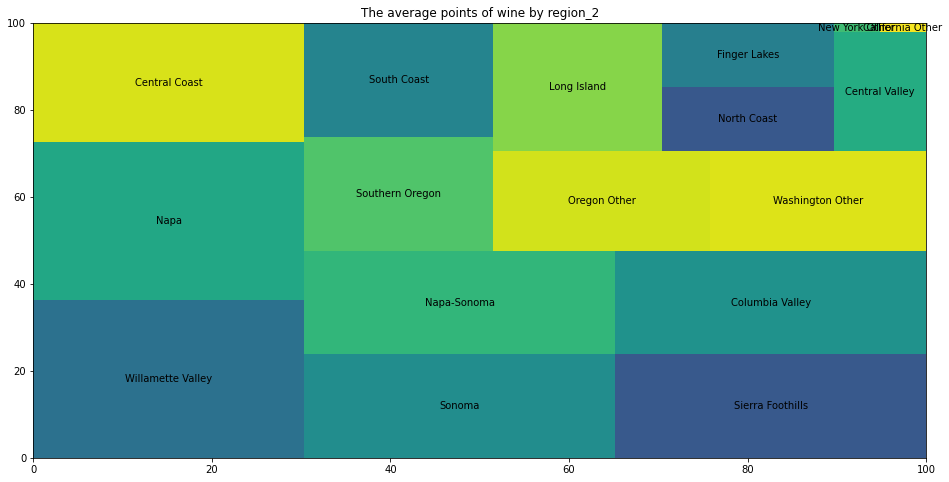

In [72]:
#collapse
print(f'Number of {column}', df[column].nunique())
cnt = df.groupby([column])['points'].median().sort_values(ascending=False).to_frame()[:30].reset_index()
plt.figure(figsize=(16,8))
squarify.plot(sizes=MinMaxScaler().fit_transform(cnt[['points']]) + 0.01, label=cnt[column])
plt.title(f'The average points of wine by {column}');

#### Imputation

Imputing values for tree-based models is unnecessary as they can handle it themselves. But if non tree based models are used, we can use a new `unknown-taster_name` to impute the missing data

In [73]:
df[column] = df[column].fillna(value=f'unknown-{column}')

#### encoding

We can onehot encode the categorical feature

In [74]:
pd.get_dummies(df[column]).columns

Index(['California Other', 'Central Coast', 'Central Valley',
       'Columbia Valley', 'Finger Lakes', 'Long Island', 'Napa', 'Napa-Sonoma',
       'New York Other', 'North Coast', 'Oregon Other', 'Sierra Foothills',
       'Sonoma', 'South Coast', 'Southern Oregon', 'Washington Other',
       'Willamette Valley', 'unknown-region_2'],
      dtype='object')

### `points`

The distribution is very gaussian and doesn't need transformation

count    9942.000000
mean       88.459264
std         3.034672
min        80.000000
25%        86.000000
50%        88.000000
75%        91.000000
max       100.000000
Name: points, dtype: float64

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa629345820>,)

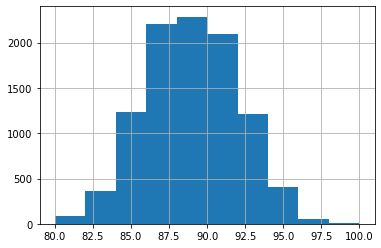

In [75]:
column = 'points'

df[column].describe()
df[column].hist(),

# Machine learning Pipeline

For this project, I followed the pipeline shown below. In this section, I will give a brief overview of what each block does and how fits into the Machine learning pipeline

![](../images/2020-09-24-ml-challenge/flowchart.png)

## Download data

This task downloads csv file and save its to a disl

## Validate data

This task compares and validate the data against expectations (~10 so far) that are derived from the data model is trained on. The expectations are based on
general understanding of the sample data that was provided. The expectations are created by observing the uniqueness, distribution and several other characteristics of each column. Preview of the validation webpage is shown here. To know more details, check out `./data_root/processed/great_expectations/unprocessed/data_docs/local_site/index.html` from the project root folder

![](../images/2020-09-24-ml-challenge/great_expectations.png)

## Visualize data

Visualize the dataset using dataprep. The html file generated(`./data_root/processed/visualize_dataset.html`) will show plots, histograms, correlations, unique value counts, and lot more information to look at. This can be helpful to understand the data and how it has impacted the model during debugging

![](../images/2020-09-24-ml-challenge/visualize_dataset.png)

## Clean data

This task is to clean the dataset using the following steps 

  - Drop columns - columns that are not important for the model 
  - Drop rows - duplicate rows based on `title`, `description` and `taster_name` will be dropped

## Make dataset

This task splits the dataset based on the `points` distribution. It does so my considering the `points` column as categorical and does stratified sampling based on the category (value) of `points`. After the split, the `points` column is converted back into float format. 

This task also adds a row with `unknown-{col_name}` value to take care of any categorical encoding that can happen later. Since there is a possiblity for encoding the categorical variables downstream, adding this columns helps in establishing `unknown-{col_name}` for each categorical column. So for any categorical column with a category that is **NOT** available during training, the value will be mapped to `unknown-{col_name}` and the dataset will be transformed without any errors. This approach also has the benefit of not amplifying most commonly occurring category

## Impute data

This task imputes the dataset for any missing values. categorical columns are imputed with `unknown-{col_name}` and numerical columns are imputed using the `median` of the column. To get more details look at the columns section of this post

## Feature engineering

This task creates new features from existing features in the dataset without replacing them (difference between feature engineering task and encoding task)

## Encode data

This task encodes columns as per the following manner. For more details, look in to the exploratory data analysis section of this post
  1. `country` - OneHotEncoder - 37 unique values
  2. `region_2` - OneHotEncoder - 17 unique values
  3. `taster_name` - OneHotEncoder - 18 unique values
  4. `variety` -  OneHotEncoder + truncatedsvd(25) - 333 unique values
  5. `province` - OneHotEncoder + truncatedsvd(25) - 248 unique values
  6. `region_1` - OneHotEncoder + truncatedsvd(25) - 724 unique values
  7. `description` - tokenize  + truncatedsvd(75) - 9942 tf-idf values
  8. `title` - tokenize  + truncatedsvd(75) - 11027 unique values
  9. `price` - log transform
  10. `grapes_used` - No transformation needed
  11. `points` - No transformation needed

## Base model

This task creates base model on the dataset created after the `make_dataset` task. The strategy is to use median value as the prediction for the output variable. This model can serve as a starting base line score

## Final model

This task develops a model that is based on the best hand-picked hyper-parameters for the dataset

The model is formulated as a supervised regression problem that is built on the sample data provided and has the capability to `predict` on the new data as well as `retrain` from scratch on the new data. Predictions will be based on the model that is created using the encoded dataset. 

### Metric

An evaluation metric measure the performance of any machine learning model. Evaluation metric depends on the problem at hand. A good evaluation metric can help the user understand the model without having an extensive inside knowledge about the model. A bad evaluation metric can make it help to map the improvement in the evaluation metric to business use case

Mean Square error is used as evaluation metric. It measures the error between true value and predicted value and averages the error over all the observations. MSE is more interpretable than other measures of regression like `R2` etc. because it is easily interpretable for this problem and familiar to lot of people. 

### Model details

Random forest regressor is used as the final model as it has some properties that are important to the current problem
 - since the dataset size is small, we do not want the model to overfit. Random forest, because of bagging, multiple trees, randomness in creating trees makes it a good candidate for constructing the regressor
 - Random Forest method of building the model and understanding the data makes it easy to understand the model at a high level very easily
 - Random Forest can also provide feature importance values based on the where and how a feature is used in the constructing the trees. However, care should be taken as Random forest importance can tend to biased in certain cases

## Evaluate model

Evaluate `base model` and `final model` performance on the test data and compare them to identify and improvements and generate a report

The evaluation report is available in the as evaluate_model.html

For evaluation data that is not used as a part of training is to used to evaluate the model so as to avoid any data leakage in to the model. MSE is computed for both the final model and base model on the test data. For the current model, I see a significant decrease in the MSE from 9 to 4.6 showing ~50% improvement over the base model. Moreover, it serves as a proof that the final model is a good predictor of wine points. Since the model can also predict on large datasets without training the entire pipeline from scratch, we can quickly check how the model performs on new data before making a decision on whether to retrain the model from scratch or not

If we look at the true and prediction distribution of the test data, we can notice that the model predictions are more close to the median of the data and less predictions towards the tail. This observations also confirms with the choice of metric which is designed to reduce the error

![](../images/2020-09-24-ml-challenge/true_values.png)
![](../images/2020-09-24-ml-challenge/final_test_predictons.png)

![](../images/2020-09-24-ml-challenge/evaluate_model.png)

## Feature Importance

This task finds out the best features that can explain the model predictions. Any estimator can be used as a final model and as long as it follows the scikit-learn API, it will be easy to generate feature importance plots. Feature importances can help in identifying what feature drive the prediction. For more details about the pipeline, check out the feature importance task section.

The feature importance values are based on the in-built values random forest estimator. Even though the permutation based feature importance is less biased and more robust, it is not used as the task can take a long time to complete. This challenge mentioned that tasks should be executed as quickly as possible. So deep neural networks or other fancy methods are not used either in several tasks

`price` seems to be a good indicator for model and its feature importance is much higher than any other feature used for modeling. So in the plot below, I have excluded `price` and used other columns to plot the following based on sorted feature importance scores

![](../images/2020-09-24-ml-challenge/feature_importance.png)

The other factors that influence the predictions are the reviewers, countries (few countries strongly influence predictions). These are in line with some the observations noticed during exploratory data analysis which confirms that the model is behaving well

# Flexibility

The machine learning pipeline constructed has the flexibility to get predictions on the big data without training the entire pipeline once again. If the performance measure is good enough and the sample dataset captures all the data characteristics of the full dataset, lot of time can be saved by training on the small data and predicting on all the data. This  leads to pipeline quantization effort in developing and deploying the model

### To run the pipeline from scratch
 - Go to project root folder
```bash
# remove all the contents from data root folder
sudo rm -rf ./data_root/*
```

- Run the pipeline to save estimators and generate all the intermediate and final files
```
docker-compose up orchestrator
```

### To use the exisiting pipeline
 - Go to project root folder

```bash
# remove all the files except estimators from previous run
sudo rm -rf ./data_root/raw/wine_dataset.csv ./data_root/SUCCESS.* ./data_root/processed/*html ./data_root/interim/*.parquet ./data_root/processed/*.parquet ./data_root/processed/*.png
```

 - Optional step - add new data URL (preferable) or add new wine_dataset.csv in the ./data_root/wine_dataset.csv

 - set RETRAIN environment variable to "false" in `orchestrator/task.py`. Do it manually

 - run the pipeline and check the progress on Luigi
```
docker-compose up orchestrator
```

# Luigi

`luigi` is used to keep track of tasks and dependencies. The machine learning pipeline mentioned above is converted to a `luigi` pipeline displayed below

![](../images/2020-09-24-ml-challenge/luigi_1.png)
![](../images/2020-09-24-ml-challenge/luigi_2.png)

# Improvements

During the course of this project, I made several choices to balance among speed, evaluation metric and complexity. I mention some of the things that can addressed to improve the performance of the model

 - There are few localized feature importance techniques like SHAP and LIME which are not explored but can help in identifying the factors that influence a prediction at observation level
 - Permutation based feature importance methods are not considered due to its time complexity. But they provided better unbiased estimates than the default random forest feature importance estimates
 - Boosting methods are not actively considered in the interest of time and boosting methods didn't play nicely in my overall approach of exploration vs exploitation strategy used during this project
 - Docker container size can be reduced by building the image from base python. Instead, I started with jupyter base image that is available on hub and used wherever I can. To generated visualizations and validations, I had to use different docker images as the jupyter docker image is not working after installing some packages required for visualization and validation